# Project 3 
## Logistic Regression
---

In [2]:
import os
os.path

<module 'ntpath' from 'C:\\Users\\606569\\AppData\\Local\\Continuum\\anaconda3\\lib\\ntpath.py'>

### What is Logistic Regression?

Linear regression: Continuous response is modeled as a linear combination of the features.

$$y = \beta_0 + \beta_1x$$

Logistic regression: Log odds of a categorical response being "true" (1) is modeled as a linear combination of the features.

$$\log \left({p\over 1-p}\right) = \beta_0 + \beta_1x$$

This is called the logit function.

Probability is sometimes written as pi.

$$\log \left({\pi\over 1-\pi}\right) = \beta_0 + \beta_1x$$

The equation can be rearranged into the logistic function.

$$\hat{p} = \frac{e^{\beta_0 + \beta_1x}} {1 + e^{\beta_0 + \beta_1x}}$$

In other words:

- Logistic regression outputs the probabilities of a specific class.
- Those probabilities can be converted into class predictions.

The logistic function has some nice properties:

- Takes on an "s" shape
- Output is bounded by 0 and 1

- The most common solution for classification models is "one-vs-all" (also known as "one-vs-rest"): Decompose the problem into multiple binary classification problems
- Multinomial logistic regression, on the other hand, can solve this as a single problem, but how this works is beyond the scope of this lesson.


# Bank Marketing Data
---

## Introduction
- Data from the UCI Machine Learning Repository: data, [data dictionary](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
- **Goal**: Predict whether a customer will purchase a bank product marketed over the phone


In [59]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

In [60]:
# import ML libraries
from sklearn.metrics import roc_curve,auc, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix

# importing libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [61]:
# silence future warnings
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [62]:
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

**Plotting a Confusion Matrix**
We will use this function later in the notebook to measure our models

## Step 1: Read the data into Pandas

In [63]:
bank = pd.read_csv('data/bank.csv')

In [64]:
bank.columns.tolist()

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']

In [65]:
print(bank.shape)
bank.head()

(4119, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


**The target `y` variable is either 
- No: 0
- Yes: 1

# EDA

Text(0.5, 1.0, 'Age Distribution')

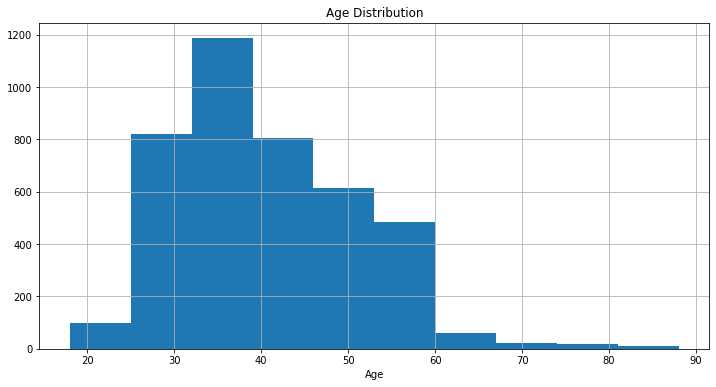

In [66]:
bank['age'].hist(figsize = (12, 6))
plt.xlabel('Age')
plt.title('Age Distribution')

## Step 2: Prepare features
- Include both numeric and categorical features
- Choose features that you think might be related to the response (based on intuition or exploration)
- Think about how to handle missing values (encoded as "unknown")

- Im going to take about 6 features and build two separate models.
- Age, Job, Marital, education, contact, day of week.

In [67]:
features = ['age','job','marital','education','contact','day_of_week','y']

for feat in features:
    if feat != 'age':
        print(bank[feat].value_counts())

admin.           1012
blue-collar       884
technician        691
services          393
management        324
retired           166
self-employed     159
entrepreneur      148
unemployed        111
housemaid         110
student            82
unknown            39
Name: job, dtype: int64
married     2509
single      1153
divorced     446
unknown       11
Name: marital, dtype: int64
university.degree      1264
high.school             921
basic.9y                574
professional.course     535
basic.4y                429
basic.6y                228
unknown                 167
illiterate                1
Name: education, dtype: int64
cellular     2652
telephone    1467
Name: contact, dtype: int64
thu    860
mon    855
tue    841
wed    795
fri    768
Name: day_of_week, dtype: int64
0    3668
1     451
Name: y, dtype: int64


**Data analysis**  
So I have some unknown values in
- `education` 
- `marital` 
- `employment`. 

- I'm going to drop the unknowns
- Another method of replacing unknowns is to build models to predict them using K Nearest neighbors, that way you are filling in an unknown using the most similar observations that you have in your data

In [68]:
# creating the sub dataframe with only the features im using
bank_a =  bank[features]

# getting rid of unknowns
bank_a = bank_a[bank_a['education'] != 'unknown']
bank_a = bank_a[bank_a['job'] != 'unknown']
bank_a = bank_a[bank_a['marital'] != 'unknown']

# Step 3: Building the Model

We can use cross-validation to evaluate the logistic regression model with our chosen features

We can use:
- **Classification accuracy/error**
  - Classification accuracy is the percentage of correct predictions (higher is better).
  - Classification error is the percentage of incorrect predictions (lower is better).
  - Easiest classification metric to understand.
- **Confusion matrix**
  - Gives you a better understanding of how your classifier is performing.
  - Allows you to calculate sensitivity, specificity, and many other metrics that might match your business objective better than accuracy.
  - Precision and recall are good for balancing misclassification costs.
- **ROC curves and area under a curve (AUC)**
  - Good for ranking and prioritization problems.
  - Allows you to visualize the performance of your classifier across all possible classification thresholds, thus helping you to choose a threshold that appropriately balances sensitivity and specificity.
  - Still useful when there is high class imbalance (unlike classification accuracy/error).
  - Harder to use when there are more than two response classes.
- **Log loss**
  - Most useful when well-calibrated predicted probabilities are important to your objective
  - Expected value calculations
    - Triage

## Model #1

For our first model we will use 
- `age`
- `job`
- `education`
- `day_of_week`

In [109]:
# md = ModelData.  Dummies ignores numeric columns such as age and y
bank_md1 = pd.get_dummies(bank_a[['age','job','education','day_of_week','y']], drop_first = True)

bank
# no hyper parameters for first model
LogReg1 = LogisticRegression()

# X and y features
X1 = bank_md1.drop('y', axis =1)
y1 = bank_md1['y']

# using train test split to cross val
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1,y1, test_size = 0.20, random_state =42)

# fit model
LogReg1.fit(x_train1, y_train1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

**Get the Coefficient's for each feature.**

In [110]:
name = bank_md1.columns.drop('y')
coef = LogReg1.coef_[0]
pd.DataFrame([name,coef],index = ['Name','Coef']).transpose()

,Name,Coef
0,age,0.0103393
1,job_blue-collar,-0.501254
2,job_entrepreneur,-1.21174
3,job_housemaid,-0.40856
4,job_management,-0.427252
5,job_retired,0.533452
6,job_self-employed,-0.403707
7,job_services,-0.465564
8,job_student,0.900865
9,job_technician,-0.0478455


**Using the model to predict on x_test and evaluate the model**

In [111]:
# predict with model
y_pred = LogReg1.predict(x_test1)

**Accuracy Score**

In [112]:
metrics.accuracy_score(y_test1,y_pred)

0.89272030651341

At first glance it looks like our model does well, with an accuracy score of almost 90, wow!
However, if we remember there are 3668 'No' and 451 'Yes'.  This mean's that if we just guessed 'No' all the time, then we would be correct 89% of the time.  This is barely better than our null model.  

### The Accuracy Paradox

Accuracy is a very intuitive metric — it's a lot like an exam score where you get total correct/total attempted. However, accuracy is often a poor metric

There are many reasons for this:
- Imbalanced problems problems with 95% positives in the baseline will have 95% accuracy even with no predictive power.
  - This is the paradox; pursuing accuracy often means predicting the most common class rather than doing the most useful work.

**Confusion Matrix**  
We have 880 True Negatives and 99 False Negatives.    
It looks like all our model is doing is predicting 'no' everytime. 

Confusion matrix, without normalization
[[699   0]
 [ 84   0]]


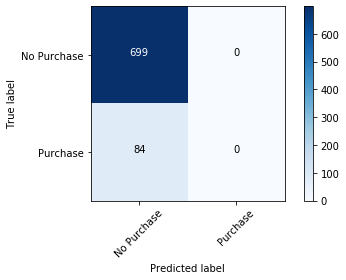

In [113]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test1, y_pred)

# Sas matrix not normalized
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Purchase','Purchase'],
                      title= '')

**ROC AUC**

The Area Under the ROC Curve is 0.5 which is completely wothless and our model gains no more insight that random guessing.  If we go back to the Accuracy score, we can now conclude that its minuscule improvement above the baseline is caused by our train test split.

In [114]:
print(f"ROC AUC Score is {metrics.roc_auc_score(y_test1,y_pred)}")

ROC AUC Score is 0.5


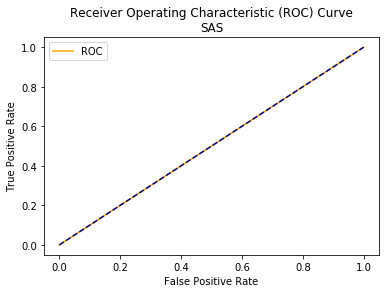

In [115]:
FPR, TPR, thresholds = roc_curve(y_test1, y_pred)

def plot_roc_curve(FPR, TPR):
    plt.plot(FPR, TPR, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve\nSAS')
    plt.legend()
    plt.show()

plot_roc_curve(FPR, TPR)

**Log Loss**

In [116]:
metrics.log_loss(y_test1,y_pred)

3.70530934504789

## Model 2:
### Using
- `age`
- `job`
- `marital`
- `education`
- `contact` 
- `day_of_week`

to predict If the bought or not.

In [118]:
# md = ModelData.  Dummies ignores numeric columns such as age and y
bank_md2 = pd.get_dummies(bank_a, drop_first = True)

# no hyper parameters for first model
LogReg2 = LogisticRegression()

# X and y features
X2 = bank_md2.drop('y', axis =1)
y2 = bank_md2['y']

# using train test split to cross val
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size = 0.20, random_state =42)

# fit model
LogReg2.fit(x_train2, y_train2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [119]:
y_pred2 = LogReg2.predict(x_test2)

In [120]:
metrics.accuracy_score(y_test2,y_pred2)

0.89272030651341

In [121]:
metrics.confusion_matrix(y_test2,y_pred2)

array([[699,   0],
       [ 84,   0]], dtype=int64)

Confusion matrix, without normalization
[[699   0]
 [ 84   0]]


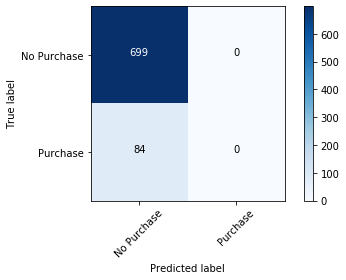

In [122]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test2, y_pred2)

# Sas matrix not normalized
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Purchase','Purchase'],
                      title= '')

In [123]:
print(f"ROC AUC Score is {metrics.roc_auc_score(y_test2,y_pred2)}")

ROC AUC Score is 0.5


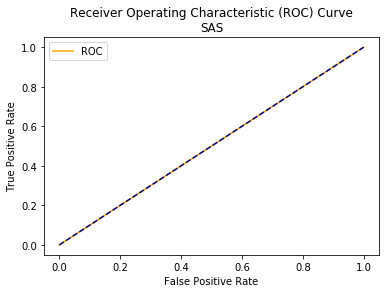

In [124]:
FPR, TPR, thresholds = roc_curve(y_test2, y_pred2)

def plot_roc_curve(FPR, TPR):
    plt.plot(FPR, TPR, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve\nSAS')
    plt.legend()
    plt.show()

plot_roc_curve(FPR, TPR)

In [125]:
metrics.log_loss(y_test2,y_pred2)

3.70530934504789

**None of the metrics have changes**

- It looks like the features we have aren't very helpful. 
- Lets do something else before grabbing more features.  
    - We will adjust the probability threshold

Use the `LogisticRegression.predict_proba()` attribute to get the probabilities.  

The first probability is the for class 0 and the second is for class 1

In [126]:
y_pred_prob = LogReg2.predict_proba(x_test2)

y_pred_prob

array([[0.82622802, 0.17377198],
       [0.93738959, 0.06261041],
       [0.81889823, 0.18110177],
       ...,
       [0.83600043, 0.16399957],
       [0.7894372 , 0.2105628 ],
       [0.97297496, 0.02702504]])

**Visuialize the distribution**

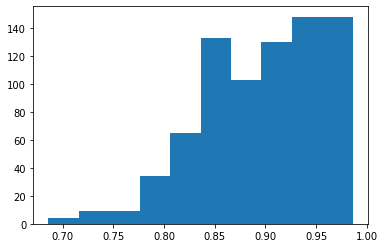

(array([148., 148., 130., 103., 133.,  65.,  34.,   9.,   9.,   4.]),
 array([0.01378201, 0.0438004 , 0.07381879, 0.10383718, 0.13385557,
        0.16387396, 0.19389234, 0.22391073, 0.25392912, 0.28394751,
        0.3139659 ]),
 <a list of 10 Patch objects>)

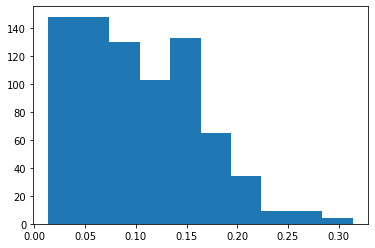

In [127]:
y_pred_prob_t = y_pred_prob.transpose()

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(y_pred_prob_t[0])
plt.show()
plt.hist(y_pred_prob_t[1])

**Calculate a new threshold and use it to convert predicted probabilities to output classes**

Lets try decreaseing the threshold to 20% predicted probability or higher.

In [128]:
y_pred3=[]
for prob in y_pred_prob_t[1]:
    if prob > .20:
        y_pred3.append(1)
    else:
        y_pred3.append(0)
        
print(len(y_pred3))
print(len(y_test2))

783
783


In [129]:
y_pred3.count(1)  #Actually made some predictions

45

In [130]:
y_pred3.count(0)

738

**Evaluate the model metrics now**

In [131]:
metrics.accuracy_score(y_test2,y_pred3)

0.8505747126436781

In [132]:
metrics.confusion_matrix(y_test2,y_pred3)

array([[660,  39],
       [ 78,   6]], dtype=int64)

Confusion matrix, without normalization
[[660  39]
 [ 78   6]]


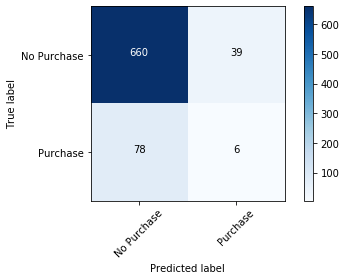

In [133]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test2,y_pred3)

# Sas matrix not normalized
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Purchase','Purchase'],
                      title= '')

In [134]:
metrics.roc_auc_score(y_test2,y_pred3)

0.5078172900061312

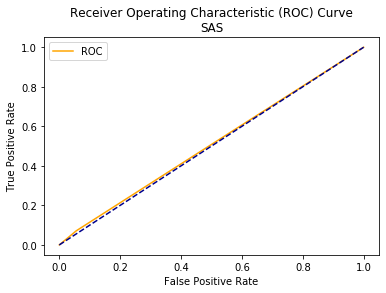

In [135]:
FPR, TPR, thresholds = roc_curve(y_test2, y_pred3)

def plot_roc_curve(FPR, TPR):
    plt.plot(FPR, TPR, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve\nSAS')
    plt.legend()
    plt.show()

plot_roc_curve(FPR, TPR)

In [136]:
metrics.log_loss(y_test2,y_pred3)

5.1610064144372

## Step 4: Build a model using all of the features.

In [137]:
bank_all = pd.get_dummies(bank, drop_first = True)

In [140]:
# no hyper parameters for first model
LogReg3 = LogisticRegression(penalty='l1',C=0.01)

# X and y features
X3 = bank_all.drop('y', axis =1)
y3 = bank_all['y']

# using train test split to cross val
x_train3, x_test3, y_train3, y_test3 = train_test_split(X3,y3, test_size = 0.20, random_state =42)

# fit model
LogReg3.fit(x_train3, y_train3)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [141]:
y_pred3 = LogReg3.predict(x_test3)

In [142]:
metrics.accuracy_score(y_test3,y_pred3)

0.904126213592233

In [143]:
metrics.confusion_matrix(y_test3, y_pred3)

array([[713,  19],
       [ 60,  32]], dtype=int64)

Confusion matrix, without normalization
[[713  19]
 [ 60  32]]


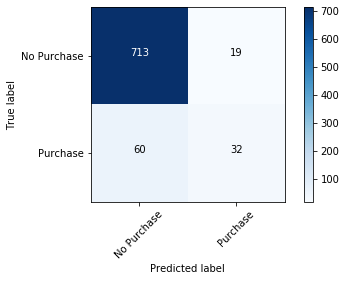

In [144]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test3,y_pred3)

# Sas matrix not normalized
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Purchase','Purchase'],
                      title= '')

In [145]:
metrics.roc_auc_score(y_test3, y_pred3)

0.6609349014017581

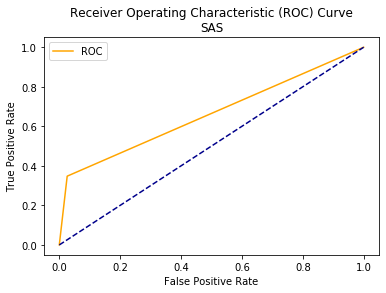

In [146]:
FPR, TPR, thresholds = roc_curve(y_test3, y_pred3)

def plot_roc_curve(FPR, TPR):
    plt.plot(FPR, TPR, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve\nSAS')
    plt.legend()
    plt.show()

plot_roc_curve(FPR, TPR)

# Use Regularization to optimize the model

In [147]:
logistic_regression_model=LogisticRegression(penalty='l1',dual=False,max_iter=110)

In [148]:
# X and y features
X = bank_all.drop('y', axis =1)
y = bank_all['y']

# using train test split to cross val
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state =42)

cees = [0.01, 0.1, 1.0, 10, 100]

for c in cees:
    logreg = LogisticRegression(penalty='l1', C=c, dual=False,max_iter=110)
    logreg.fit(x_train,y_train)
    y_pred = logreg.predict(x_test)
    roc = metrics.roc_auc_score(y_test, y_pred)
    print(roc," : ", c)

0.66991403440616  :  0.01


C:\Users\606569\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6820468378009543  :  0.1
0.6971381326639373  :  1.0
0.6947225293607866  :  10
0.6947225293607866  :  100


C:\Users\606569\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [149]:
cees = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7 ,1.8, 1.9]

for c in cees:
    logreg = LogisticRegression(penalty='l1', C=c)
    logreg.fit(x_train,y_train)
    y_pred = logreg.predict(x_test)
    roc = metrics.roc_auc_score(y_test, y_pred)
    print(roc," : ", c)

0.6965952444988993  :  1.1


C:\Users\606569\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6976810208289753  :  1.2
0.701182400462202  :  1.3
0.6965952444988993  :  1.4
0.6965952444988993  :  1.5


C:\Users\606569\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6976810208289753  :  1.6


C:\Users\606569\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6976810208289753  :  1.7


C:\Users\606569\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6976810208289753  :  1.8
0.6971381326639373  :  1.9
